In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
plt.style.use("../plotting.mplstyle")

In [3]:
data = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']

print("Data shape: {}".format(data.shape))
print("Data : {}".format(data))

Data shape: (864, 13, 35)
Data : <xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...


In [ ]:
# Use Principal Component Analysis to reduce the dimensionality of the data

In [6]:
pca_5 = ut.SpatioTemporalPCA(data, n_components=5)
pca_10 = ut.SpatioTemporalPCA(data, n_components=10)
pca_15 = ut.SpatioTemporalPCA(data, n_components=15)

print("Explained variance ratio for 5 components: {}".format(np.sum(pca_5.explained_variance())))
print("Explained variance ratio for 10 components: {}".format(np.sum(pca_10.explained_variance())))
print("Explained variance ratio for 15 components: {}".format(np.sum(pca_15.explained_variance())))

eof_5 = pca_5.eofs()
eof_10 = pca_10.eofs()
eof_15 = pca_15.eofs()

print("EOFs shape for 5 components: (eof, lat, lon) {}".format(eof_5.shape))
print("EOFs shape for 10 components: (eof, lat, lon) {}".format(eof_10.shape))
print("EOFs shape for 15 components: (eof, lat, lon) {}".format(eof_15.shape))

pc_5 = pca_5.principal_components()
pc_10 = pca_10.principal_components()
pc_15 = pca_15.principal_components()

print("PCs shape for 5 components: (eof, time) {}".format(pc_5.shape))
print("PCs data for 5 components: {}".format(pc_5))
print("PCs shape for 10 components: (eof, time) {}".format(pc_10.shape))
print("PCs shape for 15 components: (eof, time) {}".format(pc_15.shape))


Explained variance ratio for 5 components: 0.5822137848494245
Explained variance ratio for 10 components: 0.7008253235679055
Explained variance ratio for 15 components: 0.7601915080525881
EOFs shape for 5 components: (5, 13, 35)
EOFs data for 5 components: <xarray.DataArray 'ssta' (eof: 5, lat: 13, lon: 35)>
array([[[        nan,         nan,         nan, ...,  0.03284171,
          0.03886226,         nan],
        [        nan,         nan,         nan, ...,  0.03828286,
          0.03715588,         nan],
        [        nan,         nan,         nan, ...,  0.03705748,
          0.03354278,         nan],
        ...,
        [-0.01391917, -0.00304348,  0.00273921, ...,  0.01022286,
                 nan,  0.014621  ],
        [ 0.00676049, -0.0001863 ,  0.00039181, ...,  0.00638859,
          0.00713541,  0.0075418 ],
        [        nan,  0.00893918, -0.0059654 , ..., -0.00107844,
          0.00104663,  0.00066435]],

       [[        nan,         nan,         nan, ..., -0.0066103

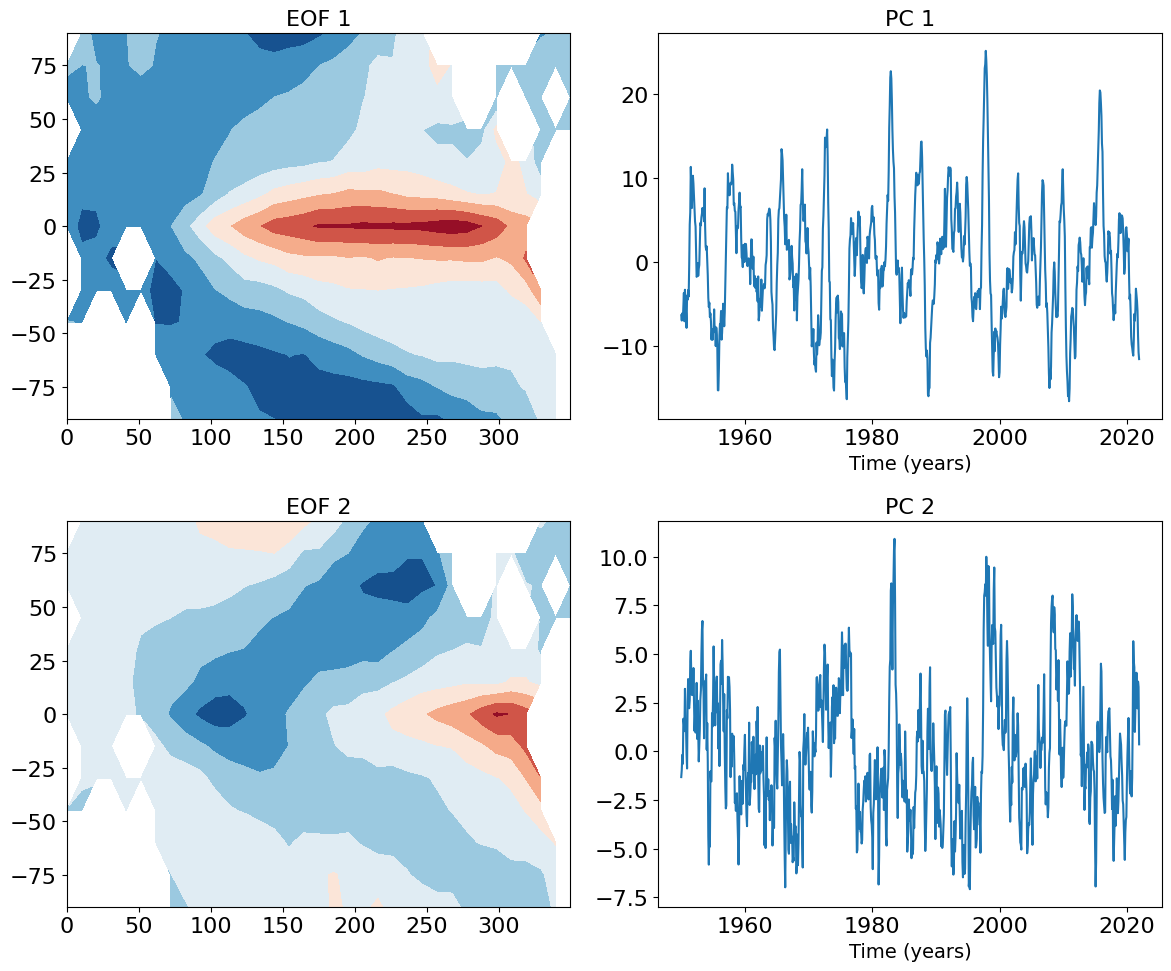

In [12]:
# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=16)
    axs[i,0].contourf(eof_10[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=16)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_10[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=14)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)

In [16]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

In [17]:
# Implementing Linear inverse model (LIM)
'''
The LIM class creates a Linear Inverse Model for time series analysis.

The class has one input parameter, tau, which represents the time lag between the input and output data.

The class has three class variables that are initialized as None:

G: Green's function
L: Logarithmic matrix
Q: Noise covariance matrix

The class has a fit method that takes in data, which is a numpy array with dimensions (n_components, n_time). The method computes the C_0 and C_tau covariance matrices of the input data, and then computes the time-evolution operator G using these covariance matrices.

The method then performs a matrix decomposition on G to obtain its eigenvectors and eigenvalues, and sorts them in descending order based on their decay time. Using these sorted eigenvectors and eigenvalues, it computes the logarithmic matrix L, which represents the linear relationship between the input and output data.

The method checks for the existence of a Nyquist mode, which occurs when the imaginary part of L is greater than a small epsilon value. If a Nyquist mode exists, a warning message is printed and the imaginary part is kept in the L matrix. If not, only the real part of L is stored. Finally, the method computes the noise covariance matrix Q using the C_0 and L matrices.

The fit method does not return any value, but it stores the computed L and Q matrices as class variables.
'''

"\nThe LIM class creates a Linear Inverse Model for time series analysis.\n\nThe class has one input parameter, tau, which represents the time lag between the input and output data.\n\nThe class has three class variables that are initialized as None:\n\nG: Green's function\nL: Logarithmic matrix\nQ: Noise covariance matrix\n\nThe class has a fit method that takes in data, which is a numpy array with dimensions (n_components, n_time). The method computes the C_0 and C_tau covariance matrices of the input data, and then computes the time-evolution operator G using these covariance matrices.\n\nThe method then performs a matrix decomposition on G to obtain its eigenvectors and eigenvalues, and sorts them in descending order based on their decay time. Using these sorted eigenvectors and eigenvalues, it computes the logarithmic matrix L, which represents the linear relationship between the input and output data.\n\nThe method checks for the existence of a Nyquist mode, which occurs when the

In [69]:
class LIM:
    """
    Linear Inverse Model for time series analysis.

    Args:
        tau (int): Time-lag for the model.
    """

    def __init__(self, tau) -> None:
        # Initialize time-lag
        self.tau = tau

        # Initialize class variables
        self.green_function = None
        self.logarithmic_matrix = None
        self.noise_covariance = None

    def fit(self, data):
        """
        Fit LIM to data.

        Args:
            data (np.ndarray): Input data to estimate Green's function from.
                Dimensions (n_components, n_time).
        """
        # Split data into x and x_tau
        x = data[:, :-self.tau]
        x_tau = data[:, self.tau:]
        assert x.shape == x_tau.shape

        # Compute the number of time points
        n_time = data.shape[1] - self.tau

        # Compute covariance matrices C_0 and C_tau
        self.C_0 = (x @ x.T) / n_time
        self.C_tau = (x_tau @ x.T) / n_time

        # Compute Green's function as C_tau x the inverse of C_0
        # time-evolution operator
        self.green_function = self.C_tau @ np.linalg.inv(self.C_0)

        # Compute Logarithmic Matrix = ln(green_function)/tau
        #Eigenvectors are vectors that satisfy the equation Ax = λx for some scalar λ. They represent the directions in which the linear transformation represented by A acts by simply scaling the vector.
        # Eigenvalues are the scalars λ that satisfy the equation Ax = λx for some vector x. They represent the magnitude of the linear transformation along the eigenvectors.
        eigenvalues, eigenvectors, _ = ut.matrix_decomposition(self.green_function)
        print("Eigenvalues - real: {}".format(eigenvalues.real))

        self.G_tau_independence_check(data)
        self.G_eigenvalue_check(eigenvalues)

        # Sort eigenvalues and eigenvectors in descending order based on decay time
        decay_time = -self.tau / np.log(eigenvalues)
        idx_sort = np.argsort(decay_time)[::-1]
        eigenvalues = eigenvalues[idx_sort]
        eigenvectors = eigenvectors[:, idx_sort]

        # Compute logarithmic matrix
        log_eigenvalues = np.diag(np.log(eigenvalues) / self.tau)
        self.logarithmic_matrix = eigenvectors @ log_eigenvalues @ np.linalg.inv(eigenvectors)

        # Check for Nyquist mode
        eps = 1e-5
        if np.max(np.abs(np.imag(self.logarithmic_matrix))) > eps:
            print("WARNING: Risk of nyquist mode.")
            print(f"WARNING: The imaginary part of L is {np.max(np.abs(np.imag(self.logarithmic_matrix)))}!")
            print(f"WARNING: Eigenvalues of G are [{np.min(eigenvalues)}, {np.max(eigenvalues)}]!")
            self.logarithmic_matrix = self.logarithmic_matrix.real
        else:
            self.logarithmic_matrix = np.real(self.logarithmic_matrix)

        # Compute noise covariance matrix Q
        self.noise_covariance = self.noise_covariance_func()

    def noise_covariance_func(self):
        """
        Estimate the noise covariance matrix.

        Assumes that the system is stationary, and estimates the noise covariance by solving the Lyapunov equation 0 = L @ C_0 + C_0 @ L.T + Q, where L is the time derivative of the Green's function and C_0 is the covariance matrix of the input data.

        Returns:
            Q (np.ndarray): Estimated noise covariance matrix of dimensions (n_components, n_components).
        """

        # Estimate the noise covariance using the Lyapunov equation
        noise_covariance = -self.logarithmic_matrix @ self.C_0 - self.C_0 @ self.logarithmic_matrix.T

        # Check if the covariance matrix has negative values
        if np.min(noise_covariance) < -1e-5:
            print(f"WARNING: Covariance matrix has negative values!")

        # Check for Nyquist mode
        # If the imaginary part of the largest eigenvalue of Q is too large, print a warning message
        eigenvalues_noise, _, _ = ut.matrix_decomposition(noise_covariance)

        # Compute the eigenvalues of Q
        eps = 1e-5
        if np.max(np.abs(np.imag(eigenvalues_noise))) > eps:
            print(f"WARNING: Imaginary part of max eigval of Q is {np.max(np.abs(np.imag(eigenvalues_noise)))}!")

        return noise_covariance

    def forecast_mean(self, x, lag=1):
        """Forecast the mean of x at time t+tau using the Green's function G.

        Args:
            x (np.ndarray): Input data to estimate Green's function from.
                Dimensions (n_components, n_time).
            lag (int): Time-lag for forecasting.

        Returns:
            x_frcst (np.ndarray): Forecast.
                Dimensions (n_components, n_time).
        """
        # Compute the matrix decomposition of G.
        eigenvalues, eigenvectors_left, eigenvectors_right = ut.matrix_decomposition(self.green_function)

        # Sort the eigenvalues in decreasing order of decay time.
        decay_times = -self.tau / np.log(eigenvalues)
        sorted_indices = np.argsort(decay_times)[::-1]

        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors_left = eigenvectors_left[:, sorted_indices]
        eigenvectors_right = eigenvectors_right[:, sorted_indices]

        # Compute weights to normalize eigenvectors left and right.
        weights = eigenvectors_left.T @ eigenvectors_right
        eigenvectors_left_norm = eigenvectors_left @ np.linalg.inv(weights)

        # Compute the Green's function at time tau*lag.
        G_tau = eigenvectors_left_norm @ np.diag(eigenvalues ** (lag / self.tau)) @ eigenvectors_right.T

        print("G_tau: {}".format(G_tau))
        # Compute the forecast x(t+tau) = G_tau * x(t).
        x_frcst = np.einsum('ij,jk', np.real(G_tau), x)

        return x_frcst

    def euler_maruyama(self, x, dt, n_samples=1):
        """Simulate the system using the Euler-Maruyama method.

        Args:
            x (np.ndarray): Input data to estimate Green's function from.
                Dimensions (n_components, n_time).
            dt (float): Time step.
            n_samples (int): Number of samples to simulate.

        Returns:
            x_sim (np.ndarray): Simulated data.
                Dimensions (n_components, n_time).
        """
        # Compute the matrix decomposition of G.
        eigenvalues, eigenvectors_left, eigenvectors_right = ut.matrix_decomposition(self.green_function)

        # Sort the eigenvalues in decreasing order of decay time.
        decay_times = -self.tau / np.log(eigenvalues)
        sorted_indices = np.argsort(decay_times)[::-1]

        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors_left = eigenvectors_left[:, sorted_indices]
        eigenvectors_right = eigenvectors_right[:, sorted_indices]

        # Compute weights to normalize eigenvectors left and right.
        weights = eigenvectors_left.T @ eigenvectors_right
        eigenvectors_left_norm = eigenvectors_left @ np.linalg.inv(weights)

        # Compute the Green's function at time tau*lag.
        G_tau = eigenvectors_left_norm @ np.diag(eigenvalues ** (dt / self.tau)) @ eigenvectors_right.T

        # Compute the forecast x(t+tau) = G_tau * x(t).
        x_sim = np.einsum('ij,jk', np.real(G_tau), x)

        return x_sim

    def G_tau_independence_check(self, data):

        x_1 = data[:, :-(self.tau+1)]
        x_tau_1 = data[:, (self.tau+1):]
        assert x_1.shape == x_tau_1.shape

        n_time_1 = data.shape[1] - (self.tau+1)

        C_0_1 = (x_1 @ x_1.T) / n_time_1
        C_tau_1 = (x_tau_1 @ x_1.T) / n_time_1

        green_function_1 = C_tau_1 @ np.linalg.inv(C_0_1)

        # Check if G is independent of tau -> eigenvalues should be equal
        # Compute the Frobenius norm of the difference between G and G_1
        fro_norm = np.linalg.norm(self.green_function - green_function_1, ord='fro')
        print("Frobenius norm: {}".format(fro_norm))

    def G_eigenvalue_check(self, eigenvalues):

        # Check for stability -> eigenvalues of G should be between 0 and 1
        if min(eigenvalues.real) < 0:
            print("WARNING: Negative eigenvalues detected.")
            print("WARNING: The logarithmic matrix may not be stable.")
            print("WARNING: Consider using a larger time-lag.")
        if max(eigenvalues.real) > 1:
            print("WARNING: Eigenvalues greater than 1 detected.")

In [70]:
# Creating an example LIM object

tau = 1
model = LIM(tau)
model.fit(data_train.data)


Eigenvalues - real: [0.89887567 0.87550434 0.87550434 0.85422079 0.85422079 0.80582136
 0.74996391 0.69132483 0.69132483 0.66062808]
Frobenius norm: 0.7287905961902055


In [71]:
lag = 2 # Forecasting lag

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data
# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

print("Forecasting mean using LIM model : {}".format(x_frcst))

G_tau: [[ 8.98460184e-01+5.97455928e-18j -1.23904735e-02-2.41378520e-18j
   1.60069206e-01-4.03592233e-17j -2.12294388e-01-1.54467716e-17j
   4.91799482e-01-1.09846645e-17j -3.53697187e-01+1.35786261e-17j
  -3.90516052e-02-3.98420737e-19j  2.91358505e-01+2.56044564e-17j
   7.53864938e-02+1.07521576e-17j  1.33339073e-01-1.41242653e-17j]
 [-6.00708669e-03+4.61493688e-18j  7.83186710e-01+1.21528984e-18j
   3.02697669e-02-1.92625327e-17j -5.69850113e-02+1.23292366e-18j
   1.19327693e-01+2.46076828e-17j -5.45271886e-02-4.95199391e-18j
  -5.01539778e-02-2.92808690e-17j -4.36520396e-03+1.06500338e-17j
  -5.52980840e-02+1.96308523e-17j  5.30131131e-02+1.21581159e-17j]
 [-1.90542667e-02-2.09944515e-18j  3.82392547e-02+2.14658528e-18j
   7.80949601e-01-2.50080751e-17j -4.29611109e-02-1.58534363e-18j
  -1.12769771e-01+4.50167316e-17j -2.59816479e-02-1.56145963e-18j
   1.36201679e-02-2.36148095e-18j  1.71083038e-02+2.77954494e-17j
  -1.80510723e-01-9.26642146e-18j  1.58658495e-02-7.51014959e-18j]


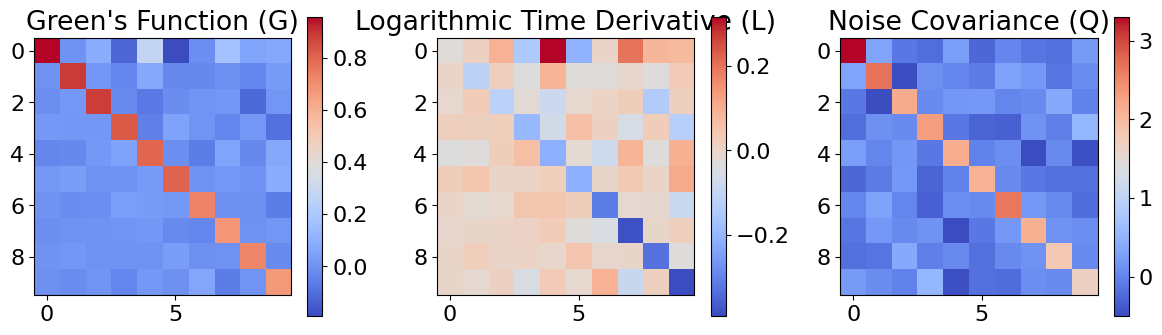

In [27]:
# Plot G, L, Q
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

# Plot G
im1 = axs[0].imshow(model.green_function, cmap='coolwarm')
axs[0].set_title('Green\'s Function (G)')
fig.colorbar(im1, ax=axs[0])

# Plot L
im2 = axs[1].imshow(np.real(model.logarithmic_matrix), cmap='coolwarm')
axs[1].set_title('Logarithmic Time Derivative (L)')
fig.colorbar(im2, ax=axs[1])

# Plot Q
im3 = axs[2].imshow(np.real(model.noise_covariance), cmap='coolwarm')
axs[2].set_title('Noise Covariance (Q)')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Time')

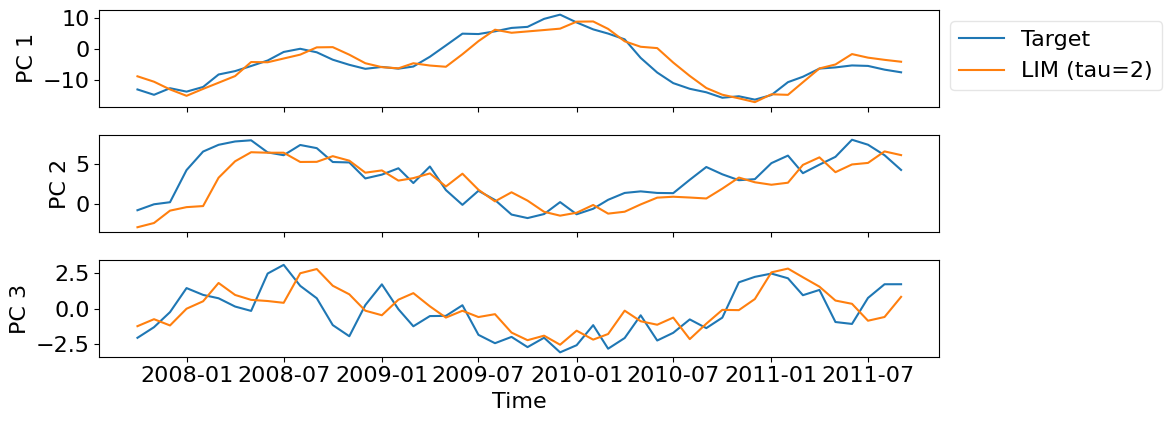

In [29]:
# Forecasting

# Define lag
lag = 2

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data

# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(12, len(idx_components)*1.5), sharex=True)

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], x_frcst[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {component+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')

Text(0.5, 1.0, 'Forecast')

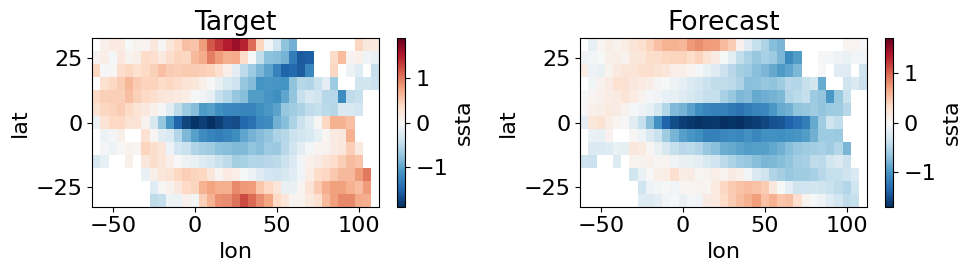

In [30]:
# Transform back to data space (denoted with y) and plot the time evolution of selected components

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(x_frcst[:, :-lag], newdim=times[lag:])

print(f"Reconstructed input data shape: {reconstructed_input.shape}")
print(f"Reconstructed forecast data shape: {reconstructed_forecast.shape}")

# Choose a time index to plot
time_index = 5

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,2, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")